In [1]:
import os

root_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
os.chdir(root_dir)

In [2]:
# import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)
# sns.set_palette("Set2")
import functions

from multiprocessing import Pool
from functools import partial

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# from ipywidgets import interact
# import ipywidgets as widgets
from scipy.signal import savgol_filter

%load_ext autoreload
%autoreload 2



# Kyte & Doolittle index of hydrophobicity
# J. Mol. Biol. 157:105-132(1982).
kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5,
      "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
      "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6,
      "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2}

#Sort kd
kd = {k: v for k, v in sorted(kd.items(), key=lambda item: item[1])}

# Flexibility
# Normalized flexibility parameters (B-values), average
# Vihinen M., Torkkila E., Riikonen P. Proteins. 19(2):141-9(1994).
flexibilities_vih = {"A": 0.984, "C": 0.906, "E": 1.094, "D": 1.068,
"G": 1.031, "F": 0.915, "I": 0.927, "H": 0.950,
"K": 1.102, "M": 0.952, "L": 0.935, "N": 1.048,
"Q": 1.037, "P": 1.049, "S": 1.046, "R": 1.008,
"T": 0.997, "W": 0.904, "V": 0.931, "Y": 0.929}

def flex(seq):
    seq = seq.replace('U', 'C')
    if len(seq) == 0:
        return 0
    else:
        return [flexibilities_vih[i] for i in seq]

def gravy(seq):
    seq = seq.replace('U', 'C')
    if len(seq) == 0:
        return 0
    else:
        return np.mean([kd[i] for i in seq])

def hydrop(seq):
    seq = seq.replace('U', 'C')
    return [kd[i] for i in seq]

def filt(seq, w=15, p=2):
    seq = seq.replace('U', 'C')
    aa = hydrop(seq)
    return savgol_filter(aa, w, p)

aa = [k for k, v in kd.items()]


def progress(iteration, total, message=None):
    '''Simple progressbar
    '''
    if message is None:
        message = ''
    bars_string = int(float(iteration) / float(total) * 50.)
    print("\r|%-50s| %d%% (%s/%s) %s "% ('█'*bars_string+ "░" * \
                                     (50 - bars_string), float(iteration)/\
                                     float(total) * 100, iteration, total, \
                                     message), end='\r', flush=True)

    if iteration == total:
        print('\nCompleted!')

aa = [k for k, v in kd.items()]
def count(seq):
    counts = [seq.count(i) for i in aa]
    return counts


In [3]:
df = pd.read_pickle('results/fungi_nonfungi.pkl.gz')
df = df.sample(frac=1, random_state=12345)

In [4]:
df.Label.value_counts()

0    1843
1     121
Name: Label, dtype: int64

In [4]:
def length_test(length):
    df['All_counts'] = df['Protein'].str[:length].apply(count)

    dfs = np.array_split(df, 5)
    #Cross validation
    ll = np.arange(5)
    mccs = []


    for j in range(5):
        test_idx = j
        train_idx = list(set(ll) - set([j]))

        test = dfs[j]
        train = pd.concat([dfs[i] for i in train_idx])

        train = train.reset_index(drop=True)
        train = train.sample(frac=1, random_state=12345).copy()

        #Making random forest


        X_train = [i for i in train['All_counts']]
        y_train = train['Label'].values

        X_test = [i for i in test['All_counts']]
        y_test = test['Label'].values


        clf = RandomForestClassifier(random_state=12345, n_jobs=-1)
        clf.fit(X_train, y_train)



        preds = [i[1] for i in clf.predict_proba(X_test)]
        dfs[j]['SP_Prediction'] = preds



        mcc = []

        for i, v in enumerate(np.arange(0.01, 0.99, 0.01)):
            y_pred = [0 if x <= v else 1 for x in preds]
            mcc.append(matthews_corrcoef(y_test, y_pred))

        mccs.append(max(mcc))
    return mccs


In [7]:
a = []

for i, v in enumerate(range(15, 31, 1)):
    m = length_test(v)
    a.append(m)

    functions.progress(i+1, 15)

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhand

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Completed!


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [29]:
lengths = list(range(15, 31, 1))
test_df = pd.DataFrame(index=lengths, columns=list(range(1, 6)))

for i, v in enumerate(a):
    for p, mc in enumerate(v):
        test_df.loc[lengths[i]][p+1] = mc


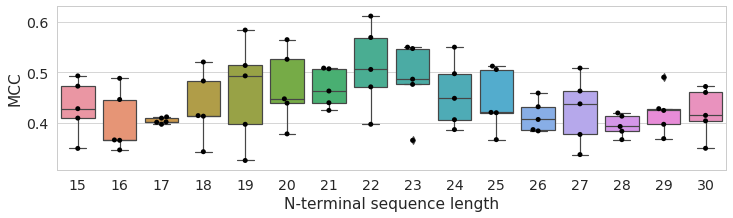

In [44]:
plt.figure(figsize=(12, 3))
# sns.pointplot(y=test_df.median(axis=1).round(3).values, x=list(range(15, 31)))
sns.swarmplot(x="variable", y="value", data=test_df.transpose().melt(), color="black")
ax = sns.boxplot(x="variable", y="value", data=test_df.transpose().melt())
ax.set_ylabel('MCC')
ax.set_xlabel('N-terminal sequence length');
# plt.savefig('figs/Fungi_Classifier_CV_Length.pdf', bbox_inches='tight', pad_inches=0);

In [9]:
test_df.to_pickle('results/Fungi_Classifier_CV_Length.pkl.gz')

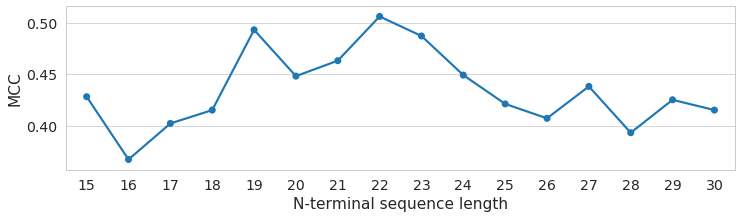

In [41]:
plt.figure(figsize=(12, 3))
ax = sns.pointplot(y=test_df.median(axis=1).round(3).values, x=list(range(15, 31)))
ax.set_ylabel('MCC')
ax.set_xlabel('N-terminal sequence length');